In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [2]:
# Work is done, csv ya procesado
# # Load original CSV
# df = pd.read_csv('data/birdclef-2021/train_metadata.csv')

# # Drop rows without coordinates
# df = df.dropna(subset=['latitude', 'longitude', 'filename'])

# # Keep only specified columns
# cols = ['primary_label', 'latitude', 'longitude', 'scientific_name', 'common_name', 'filename', 'rating']
# df = df[cols]

# # Overwrite original file
# df.to_csv('data/birdclef-2021/train_metadata.csv', index=False)
# df.to_csv('database/train_metadata.csv', index=False)

# # Preview
# df.head(n=10)

In [3]:
df = pd.read_csv('database/train_metadata.csv')
print(f"DataFrame shape: {df.shape}")
df = df.dropna(subset=['latitude', 'longitude'])
df = df[df['filename'].notna() & (df['filename'] != '')]
df = df[~(df['scientific_name'].isna() & df['common_name'].isna())]
print(f"DataFrame shape after 'cuts': {df.shape}")

DataFrame shape: (62874, 7)
DataFrame shape after 'cuts': (62874, 7)


In [4]:
df.head(n=10)

,primary_label,latitude,longitude,scientific_name,common_name,filename,rating
0,acafly,35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,XC109605.ogg,2.5
1,acafly,9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,XC11209.ogg,3.0
2,acafly,5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,XC127032.ogg,3.0
3,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC129974.ogg,3.5
4,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC129981.ogg,3.5
5,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC130056.ogg,4.0
6,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC130133.ogg,4.0
7,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC130140.ogg,4.0
8,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC130750.ogg,4.0
9,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC131193.ogg,3.0


In [5]:
# BOUNDS FOR SAMPLES CUT-OFF

# Bounding box for Latin America (min_lat, max_lat, min_lon, max_lon)
latin_america_bounds = {
    "lat": (-55.0, -20),
    "lon": (-73, -53)
}

MIN_SAMPLES_CUTOFF = 12
MIN_RATING_CUTOFF = 3.0

In [6]:
def in_region(lat, lon):
    return (latin_america_bounds['lat'][0] <= lat <= latin_america_bounds['lat'][1] and
            latin_america_bounds['lon'][0] <= lon <= latin_america_bounds['lon'][1])

df['region'] = df.apply(lambda row: 'Latin America' if in_region(row['latitude'], row['longitude']) else None, axis=1)
region_df = df[df['region'].notna()][['primary_label', 'latitude', 'longitude', 'scientific_name', 'common_name', 'region', 'filename']]

# Add sample count per species
species_counts = region_df['scientific_name'].value_counts().to_dict()
region_df['amount_of_samples'] = region_df['scientific_name'].map(species_counts)

total_samples = len(region_df)
total_species = region_df['scientific_name'].nunique()

print(f"Total samples: {total_samples}")
print(f"Total distinct species: {total_species}")

Total samples: 961
Total distinct species: 78


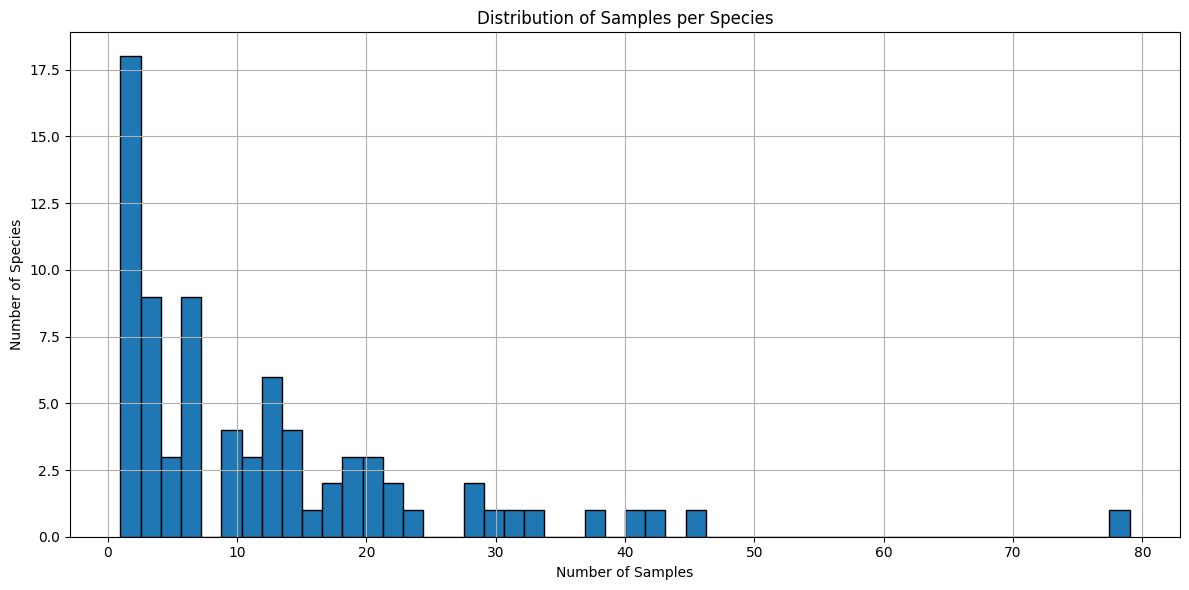

In [7]:
species_counts = region_df['scientific_name'].value_counts()

plt.figure(figsize=(12, 6))
species_counts.hist(bins=50, edgecolor='black')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Species')
plt.title('Distribution of Samples per Species')
plt.grid(True)
plt.tight_layout()
plt.show()

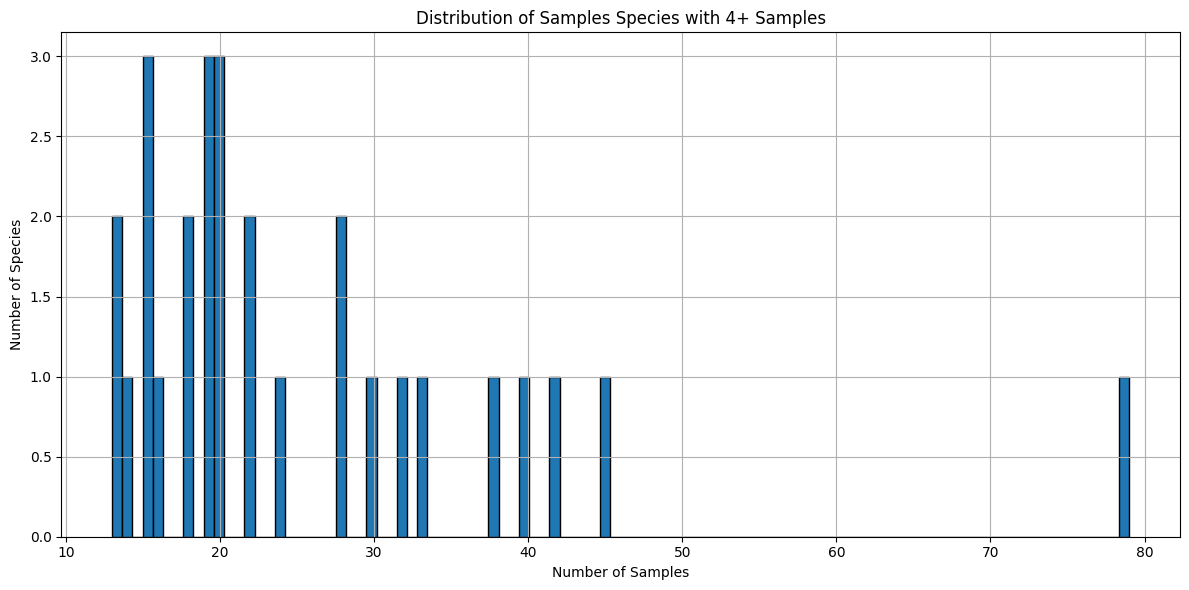

Total samples: 717
Total distinct species: 28


In [8]:
species_counts_filtered = species_counts[species_counts > MIN_SAMPLES_CUTOFF]
filtered_region_df = region_df[region_df['scientific_name'].isin(species_counts_filtered.index)]

plt.figure(figsize=(12, 6))
species_counts_filtered.hist(bins=100, edgecolor='black')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Species')
plt.title('Distribution of Samples Species with 4+ Samples')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Total samples: {len(filtered_region_df)}")
print(f"Total distinct species: {filtered_region_df['scientific_name'].nunique()}")

In [9]:
rated_df = filtered_region_df[df.loc[filtered_region_df.index, 'rating'] >= MIN_RATING_CUTOFF]
total_samples = len(rated_df)
total_species = rated_df['scientific_name'].nunique()

print(f"Total samples: {total_samples}")
print(f"Total distinct species: {total_species}")

Total samples: 575
Total distinct species: 28


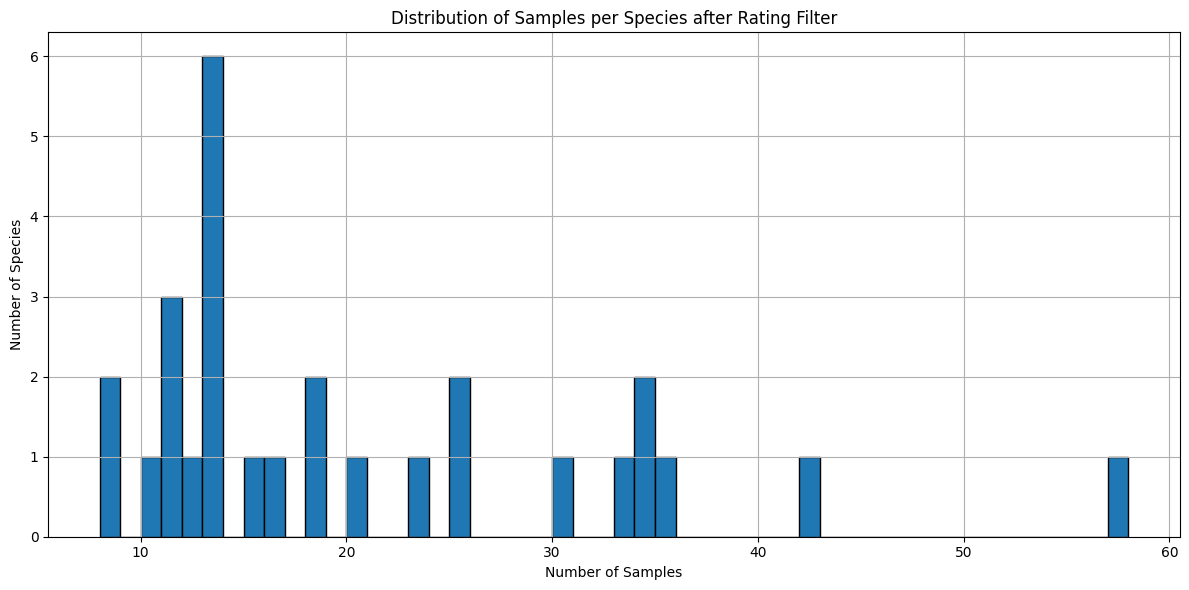

In [10]:
rated_species_counts = rated_df['scientific_name'].value_counts()

plt.figure(figsize=(12, 6))
rated_species_counts.hist(bins=50, edgecolor='black')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Species')
plt.title('Distribution of Samples per Species after Rating Filter')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Final Amount of Samples and Species
print(f"Final amount of samples: {len(rated_df)}")
print(f"Final amount of species: {rated_df['scientific_name'].nunique()}")

# Save to CSV
final_df = rated_df[['primary_label', 'scientific_name', 'common_name', 'filename']].copy()
final_df.to_csv('database/meta/final_species.csv', index=False)

Final amount of samples: 575
Final amount of species: 28


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df['class_id'] = le.fit_transform(final_df['scientific_name'])

# Build mapping with class_id, scientific_name, common_name
mapping_df = final_df[['class_id', 'scientific_name', 'common_name']].drop_duplicates().sort_values('class_id')
mapping_df.to_csv('database/meta/class_mapping.csv', index=False)

# Create training metadata with filename and class_id
train_metadata = final_df[['filename', 'class_id']]
train_metadata.to_csv('database/meta/train_data.csv', index=False)